## Context
This is image data of Natural Scenes around the world.

## Content
This Data contains around 25k images of size 150x150 distributed under 6 categories.<br>
{'buildings' -> 0,<br>
'forest' -> 1,<br>
'glacier' -> 2,<br>
'mountain' -> 3,<br>
'sea' -> 4,<br>
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

### Import necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os 
import torch 
import torchvision
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision.transforms import ToTensor 
import torchvision.transforms as tt 
from torchvision.utils import make_grid 
from torch.utils.data.dataloader import DataLoader 
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split 
%matplotlib inline 

In [2]:
print(torch.__version__)

print(torchvision.__version__)

print(torch.version.cuda)

2.3.1+cu121
0.18.1+cu121
12.1


In [3]:
train = ImageFolder("/config/workspace/Data/seg_train",transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))

In [4]:
train.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
train_dl = DataLoader(train,64,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
def get_mean_std(dl):
    sum_,sqaured_sum,batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data,dim=([0,2,3]))
        sqaured_sum += torch.mean(data**2,dim=([0,2,3]))
        batches += 1

    mean = sum_/batches
    std = (sqaured_sum/batches - mean**2)**0.5
    return mean,std 

mean,std = get_mean_std(train_dl)
mean,std 

(tensor([0.4302, 0.4575, 0.4539]), tensor([0.2481, 0.2467, 0.2806]))

In [8]:
stats = ((0.4302, 0.4575, 0.4539),(0.2481, 0.2467, 0.2806))
train_transfrom = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transfrom = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [9]:
train = ImageFolder("/config/workspace/Data/seg_train/",transform=train_transfrom)
test = ImageFolder("/config/workspace/Data/seg_test/",transform=test_transfrom)

In [10]:
random_seed = 42
torch.manual_seed(random_seed)

In [11]:
val_size = int(len(train)*0.2)
train_size = len(train) - val_size 

train_ds , val_ds = random_split(train,[train_size,val_size])
len(train_ds),len(val_ds)

(11228, 2806)

In [12]:
batch_size = 128 

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_dl = DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)
test_dl = DataLoader(test,batch_size*2,num_workers=2,pin_memory=True)

In [13]:
def denormalize(iamges,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return iamges * stds + means 

def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images = denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break 

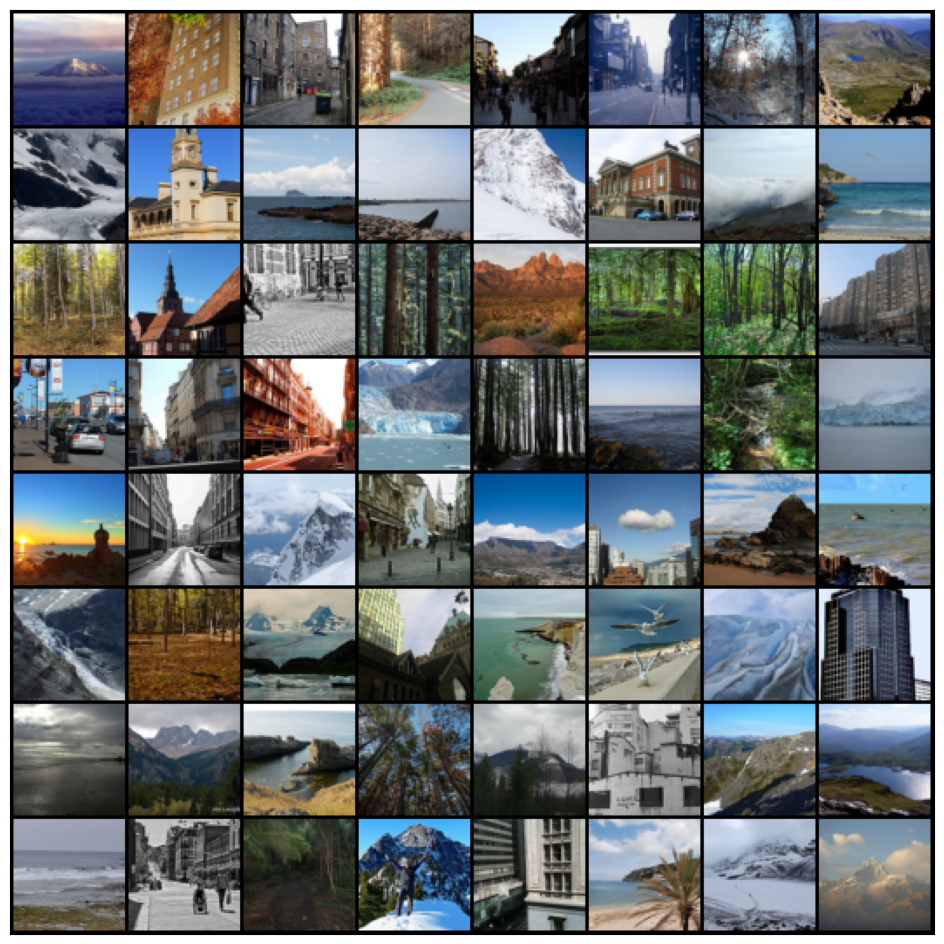

In [14]:
show_batch(train_dl)

In [16]:
def get_default_device():
    """ Pick GPU if available , else CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    """ Move tensor(s) to chosen device """
    if isinstance(data,(list,tuple)):
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to device """ 
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device 

    def __iter__(self):
        """ yield a batch of data after moving it to device """
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(slef):
        """ Number of Batches """ 
        return len(self.dl)

In [17]:
get_default_device()

device(type='cpu')

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels = batch_size
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(slef,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,lables)
        acc = accuaracy(out,labels)
        return {'val_loss':loss.detach(),'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss']for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc']for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr:{:.5f},train_loss:{:.4f},val_loss:{:.4f},val_acc:{:.4f}".format(
            epoch,result['lrs'][-1],result['train_loss'],result['val_loss'],result['val_acc']))

def accuaracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [19]:
device = get_default_device()
device

device(type='cpu')

In [20]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

## Building the Model